In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms    
import random
import cv2
import torch
from PIL import Image
from torch.nn import Module, Sequential,Linear, Dropout, Flatten, ReLU
from torch.utils.data import DataLoader 
from torch.nn.functional import softmax, cross_entropy
from torch.optim import Adam                   # 경사 하강법.
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v2
from torchvision.models import resnet50
from torchvision.models import vgg16
%matplotlib inline

## 데이터 가져오기

In [ ]:
data_dir =  r'/content/drive/MyDrive/뮤지컬 프로젝트/flowers'
#p = Augmentor.Pipeline("/content/drive/MyDrive/뮤지컬 프로젝트/flowers")

In [ ]:
os.listdir(data_dir)

['daisy', 'dandelion', 'tulip', 'sunflower', 'rose']

In [ ]:
flower_classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## 데이터 전처리

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(255),     # 전체 데이터셋 사이즈 맞추기
                                transforms.CenterCrop(224), # 중간 부분 Crop
                                transforms.ToTensor(),      # 자료형 바꾸기
                                transforms.Normalize((0.5,), (0.5,)) # 색 맞추기 (평균, 표준편차)
                               ])
dataset = datasets.ImageFolder(data_dir, transform = transform)
num = len(dataset)
test_size = 0.3
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(test_size * num))
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset, batch_size = 32, sampler = train_sampler)
test_loader = DataLoader(dataset, batch_size = 32, sampler = test_sampler)

## 학습전 랜덤 데이터 출력

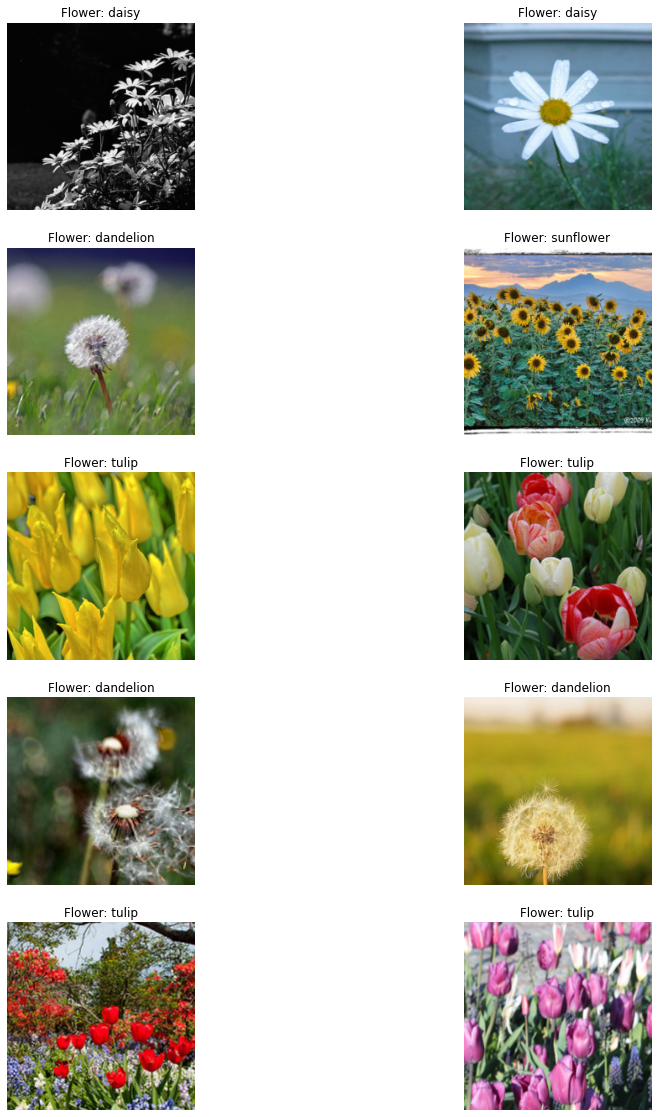

In [ ]:
images, labels = next(iter(train_loader))
# any 10 random images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 20)
idx = 0
for i in range(5):
    for j in range(2):
#         Convert to numpy for display
        image = images[idx].numpy()
#       Denormalize for display
        image = image / 2 + 0.5
        ax[i, j].set_axis_off()
        ax[i, j].imshow(image.transpose(1,2,0))
        ax[i, j].set_title('Flower: ' + flower_classes[labels[idx]])
        idx = idx + 1

In [ ]:
# 랜덤 시드 설정.
torch.manual_seed(123)

In [ ]:
# CPU 또는 GPU 선택.
my_device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")  

## 1차 최적화 : CNN 알고리즘 적용

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        #         ->224x224x3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #         ->112x112x32
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        #         ->56x56x64
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        #         ->28x28x128
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        #         ->14x14x256
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        #         ->7x7x512
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(7 * 7 * 512, 500)
        self.fc2 = nn.Linear(500, 5)
        self.dropout = nn.Dropout(p = 0.25)
        
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        X = self.pool(F.relu(self.conv5(X)))

        X = X.view(-1, 7 * 7* 512)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return X

In [ ]:
model = Classifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

- Train

In [ ]:
n_epochs = 15
history = []
epochs = []
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    #history.append(epoch)
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
        
    train_loss = train_loss/len(train_loader.sampler)
    
    history.append([epoch,train_loss])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

In [ ]:
history

[[1, 1.346176968781064],
 [2, 1.1109759971701143],
 [3, 1.0078008165450802],
 [4, 0.9061034076006824],
 [5, 0.8132040953037959],
 [6, 0.7269022411621613],
 [7, 0.6516487756236704],
 [8, 0.5417514621089811],
 [9, 0.44856817037919916],
 [10, 0.32970718415155786],
 [11, 0.25989116354915875],
 [12, 0.22952243354148147],
 [13, 0.20915121067353465],
 [14, 0.15203890617667506],
 [15, 0.12080657018607463]]

In [ ]:
# 1. inline for loop 사용
epoch_first = [i[0] for i in history]
print(epoch_first)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
loss_first = []
for i in history:
    loss_first.append(i[1])
print(loss_first)

[1.346176968781064, 1.1109759971701143, 1.0078008165450802, 0.9061034076006824, 0.8132040953037959, 0.7269022411621613, 0.6516487756236704, 0.5417514621089811, 0.44856817037919916, 0.32970718415155786, 0.25989116354915875, 0.22952243354148147, 0.20915121067353465, 0.15203890617667506, 0.12080657018607463]


In [ ]:
first_df = pd.DataFrame(loss_first,epoch_first, columns=['Loss'])
first_df

,Loss
1,1.346177
2,1.110976
3,1.007801
4,0.906103
5,0.813204
6,0.726902
7,0.651649
8,0.541751
9,0.448568
10,0.329707


- Test

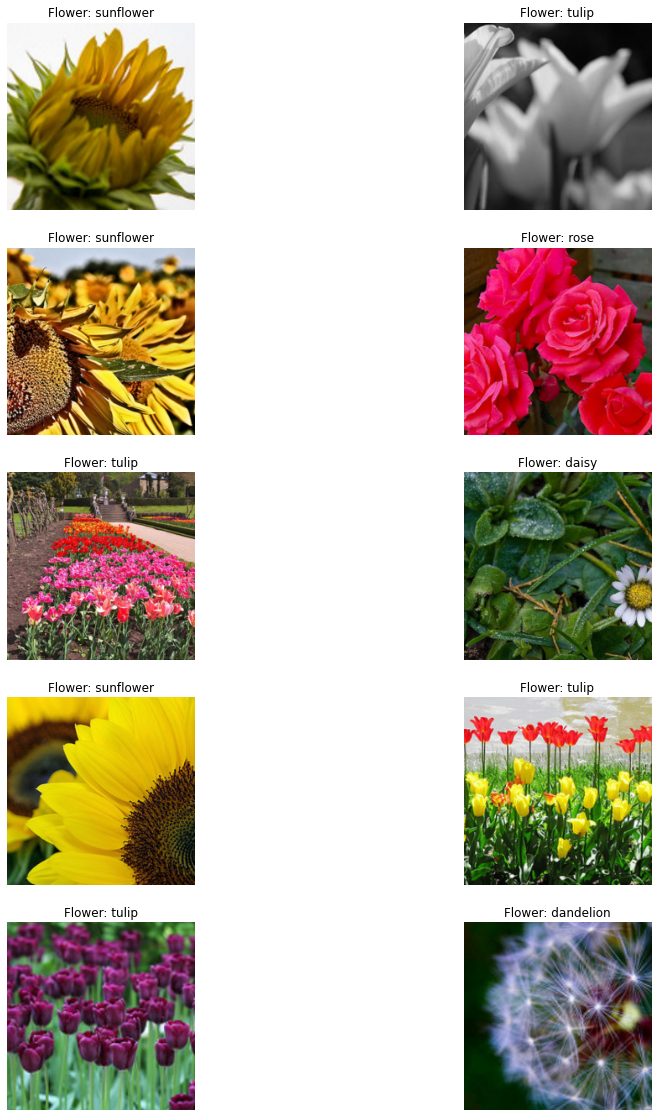

In [ ]:
images, labels = next(iter(test_loader))
# any 10 random images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 20)
idx = 0
for i in range(5):
    for j in range(2):
#         Convert to numpy for display
        image = images[idx].numpy()
#       Denormalize for display
        image = image / 2 + 0.5
        ax[i, j].set_axis_off()
        ax[i, j].imshow(image.transpose(1,2,0))
        ax[i, j].set_title('Flower: ' + flower_classes[labels[idx]])
        idx = idx + 1

In [ ]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.450297

Test Accuracy of daisy: 77% (169/218)
Test Accuracy of dandelion: 75% (249/329)
Test Accuracy of  rose: 55% (131/236)
Test Accuracy of sunflower: 83% (172/205)
Test Accuracy of tulip: 66% (204/309)

Test Accuracy (Overall): 71% (925/1297)


- 1차 시각화

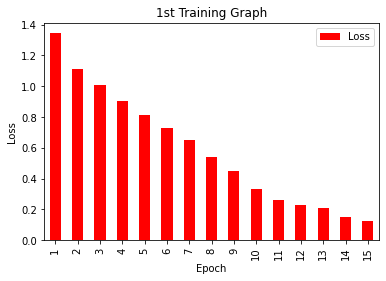

In [ ]:
first_df.plot.bar(color='red')
plt.title('1st Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 2차  하이퍼 파라미터 최적화 : CNN 알고리즘 적용(+ 초기함수)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(2 * 2 * 64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.conv1_bn = nn.BatchNorm2d(8)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.dropout_p = 0.2
        
    def forward(self, X):
        X = self.conv1(X) # 32 * 32 * 3 -> 32 * 32 * 8
        X = self.conv1_bn(X)
        X = F.tanh(X)     # 32 * 32 * 8
        X = self.pool(X)  # 16 * 16 * 8
        
        X = self.conv2(X) # 16 * 16 * 8 -> 16 * 16 * 16
        X = self.conv2_bn(X)
        X = F.tanh(X)     # 16 * 16 * 16
        X = self.pool(X)  # 8  *  8 * 16
        
        X = self.conv3(X) # 8 * 8 * 16 -> 8 * 8 * 32
        X = self.conv3_bn(X)
        X = F.tanh(X)     # 8 * 8 * 32
        X = self.pool(X)  # 4 * 4 * 32
        
        X = self.conv4(X) # 4 * 4 * 32 -> 4 * 4 * 64
        X = self.conv4_bn(X)
        X = F.tanh(X)     # 4 * 4 * 64
        X = self.pool(X)  # 2 * 2 * 64
        
        X = x.view(-1, 2 * 2 * 64)
        X = self.fc1(X)
        X = F.dropout(x, p = self.dropout_p)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.dropout(X, p = self.dropout_p)
        X = F.relu(X)
        X = self.fc3(X)
        X = F.log_softmax(X, dim = 1)
        return X

import torch.nn.init as init
def weight_init(m):
    
    '''
    초기값 설정방법들 
    Ref: https://pytorch.org/docs/stable/nn.init.html
    
    init.uniform_(tensor, a = 0.0, b = 1.0) (a: Lower bound, b: Upper bound)
    init.normal_(tensor, mean = 0.0, std = 1.0)
    init.xavier_uniform_(tensor, gain = 1.0)
    init.xavier_normal_(tensor, gain = 1.0)
    init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
    init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
    '''
    
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)
        init.normal_(m.bias.data)
        
model = CNN().to(device)
model.apply(weight_init)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
model = Classifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

- Train

In [ ]:
n_epochs = 15
second_history = []
second_epochs = []
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    #history.append(epoch)
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
        
    train_loss = train_loss/len(train_loader.sampler)
    
    second_history.append([epoch,train_loss])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 1.299588
Epoch: 2 	Training Loss: 1.106335
Epoch: 3 	Training Loss: 1.009274
Epoch: 4 	Training Loss: 0.940759
Epoch: 5 	Training Loss: 0.840082
Epoch: 6 	Training Loss: 0.763263
Epoch: 7 	Training Loss: 0.686697
Epoch: 8 	Training Loss: 0.600293
Epoch: 9 	Training Loss: 0.511117
Epoch: 10 	Training Loss: 0.402333
Epoch: 11 	Training Loss: 0.321285
Epoch: 12 	Training Loss: 0.229104
Epoch: 13 	Training Loss: 0.173952
Epoch: 14 	Training Loss: 0.148535
Epoch: 15 	Training Loss: 0.105441


In [ ]:
second_history

[[1, 1.299588413709223],
 [2, 1.1063354463811832],
 [3, 1.0092742036340574],
 [4, 0.9407594560514232],
 [5, 0.8400824981067944],
 [6, 0.7632627991824782],
 [7, 0.6866969360341802],
 [8, 0.6002925400019243],
 [9, 0.511117353754966],
 [10, 0.40233348694206583],
 [11, 0.32128516733449614],
 [12, 0.22910437181705137],
 [13, 0.17395176305461732],
 [14, 0.14853492567605334],
 [15, 0.10544118058636229]]

In [ ]:
# 1. inline for loop 사용
epoch_second = [i[0] for i in second_history]
print(epoch_second)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
loss_second = []
for i in second_history:
    loss_second.append(i[1])
print(loss_second)

[1.299588413709223, 1.1063354463811832, 1.0092742036340574, 0.9407594560514232, 0.8400824981067944, 0.7632627991824782, 0.6866969360341802, 0.6002925400019243, 0.511117353754966, 0.40233348694206583, 0.32128516733449614, 0.22910437181705137, 0.17395176305461732, 0.14853492567605334, 0.10544118058636229]


In [ ]:
second_df = pd.DataFrame(loss_second,epoch_second, columns=['Loss'])
second_df

,Loss
1,1.299588
2,1.106335
3,1.009274
4,0.940759
5,0.840082
6,0.763263
7,0.686697
8,0.600293
9,0.511117
10,0.402333


- Test

In [ ]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.482888

Test Accuracy of daisy: 99% (231/233)
Test Accuracy of dandelion:  0% ( 0/298)
Test Accuracy of  rose:  0% ( 0/245)
Test Accuracy of sunflower:  1% ( 4/227)
Test Accuracy of tulip:  0% ( 2/294)

Test Accuracy (Overall): 18% (237/1297)


- 2차 학습 시각화 

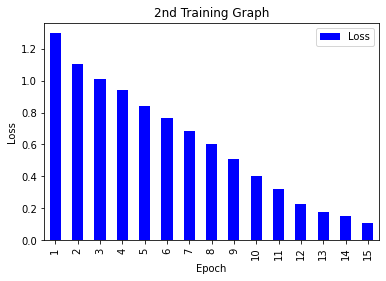

In [ ]:
second_df.plot.bar(color='blue')
plt.title('2nd Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 3차 하이퍼 파라미터 최적화 : CNN 알고리즘 적용 (+ ResNet)

- Pretrained Model 사용 X

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = ResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

print("device: ", device)
print("MODEL: ", model)

device:  cuda
MODEL:  ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05,

In [ ]:
model = ResNet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = models.resnet18(pretrained = False).cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 30
third_history = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, train_loader)

    third_history.append([epoch,test_loss])
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/4326 (0%)]	Loss: 7.193778
[1] Test Loss: 0.7928, accuracy: 42.97%

Train Epoch: 2 [0/4326 (0%)]	Loss: 0.604567
[2] Test Loss: 0.5495, accuracy: 51.06%

Train Epoch: 3 [0/4326 (0%)]	Loss: 0.806566
[3] Test Loss: 0.5965, accuracy: 47.57%

Train Epoch: 4 [0/4326 (0%)]	Loss: 0.518886
[4] Test Loss: 0.5799, accuracy: 46.12%

Train Epoch: 5 [0/4326 (0%)]	Loss: 0.655691
[5] Test Loss: 0.3805, accuracy: 57.19%

Train Epoch: 6 [0/4326 (0%)]	Loss: 0.587333
[6] Test Loss: 0.2090, accuracy: 64.08%

Train Epoch: 7 [0/4326 (0%)]	Loss: 0.229126
[7] Test Loss: 0.3075, accuracy: 59.11%

Train Epoch: 8 [0/4326 (0%)]	Loss: 0.104662
[8] Test Loss: 0.0607, accuracy: 68.84%

Train Epoch: 9 [0/4326 (0%)]	Loss: 0.084536
[9] Test Loss: 0.0650, accuracy: 68.12%

Train Epoch: 10 [0/4326 (0%)]	Loss: 0.032195
[10] Test Loss: 0.0406, accuracy: 69.05%

Train Epoch: 11 [0/4326 (0%)]	Loss: 0.012391
[11] Test Loss: 0.0265, accuracy: 69.53%

Train Epoch: 12 [0/4326 (0%)]	Loss: 0.073166
[12] Test Loss: 

In [ ]:
third_history

[[1, 0.7927540013264354],
 [2, 0.5495266601326175],
 [3, 0.5965270742574226],
 [4, 0.5798635522469403],
 [5, 0.3804986059142107],
 [6, 0.20902293289473803],
 [7, 0.3074785811009365],
 [8, 0.060734903501020336],
 [9, 0.06500026837191095],
 [10, 0.04056783210636012],
 [11, 0.026457830178506166],
 [12, 0.05106097240030242],
 [13, 0.023809092177032486],
 [14, 0.014048600487559139],
 [15, 0.018981989226818527],
 [16, 0.012884301383614925],
 [17, 0.028429187589699177],
 [18, 0.005943462055415893],
 [19, 0.05011510996942822],
 [20, 0.03159420944533302],
 [21, 0.013062335034101251],
 [22, 0.01748072973422799],
 [23, 0.0025831758554024217],
 [24, 0.0014235620526618432],
 [25, 0.002664577527534883],
 [26, 0.019954456102320002],
 [27, 0.0530474370744181],
 [28, 0.017479106527247254],
 [29, 0.0047063229765296945],
 [30, 0.00513804451206383]]

In [ ]:
# 1. inline for loop 사용
epoch_third = [i[0] for i in third_history]
print(epoch_third)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [ ]:
loss_third = []
for i in third_history:
    loss_third.append(i[1])
print(loss_third)

[0.7927540013264354, 0.5495266601326175, 0.5965270742574226, 0.5798635522469403, 0.3804986059142107, 0.20902293289473803, 0.3074785811009365, 0.060734903501020336, 0.06500026837191095, 0.04056783210636012, 0.026457830178506166, 0.05106097240030242, 0.023809092177032486, 0.014048600487559139, 0.018981989226818527, 0.012884301383614925, 0.028429187589699177, 0.005943462055415893, 0.05011510996942822, 0.03159420944533302, 0.013062335034101251, 0.01748072973422799, 0.0025831758554024217, 0.0014235620526618432, 0.002664577527534883, 0.019954456102320002, 0.0530474370744181, 0.017479106527247254, 0.0047063229765296945, 0.00513804451206383]


In [ ]:
third_df = pd.DataFrame(loss_third,epoch_third, columns=['Loss'])
third_df

,Loss
1,0.792754
2,0.549527
3,0.596527
4,0.579864
5,0.380499
6,0.209023
7,0.307479
8,0.060735
9,0.065000
10,0.040568


- 3차 시각화

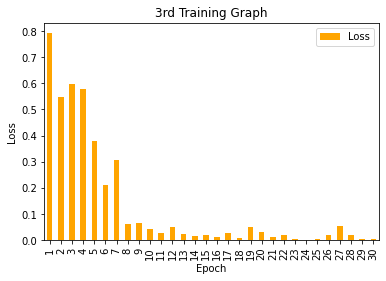

In [ ]:
third_df.plot.bar(color='orange')
plt.title('3rd Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

- Pretrained Model 사용 o

In [ ]:
# 모델을 가져와서 구조를 본다.
my_model = resnet50(pretrained=True).to(my_device)
print(my_model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
# "FC" 부분만 다시 정의한다.
my_model.fc = Sequential(Flatten(),
                                Dropout(p=0.5),
                                Linear(in_features=2048, out_features = 1024, bias=True), 
                                ReLU(),
                                Dropout(p=0.5),
                                Linear(in_features=1024, out_features = 256, bias=True), 
                                ReLU(),
                                Linear(in_features=256, out_features = 10, bias=True)).to(my_device)
print(my_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 일단 가중치를 동결해 둔다.
for params in my_model.parameters():
    params.require_grad = False
    
# "FC" 부분의 가중치만 풀어준다.
for params in my_model.fc.parameters():
    params.requires_grad = True

In [ ]:
# ResNet50 입력을 위한 전처리 함수.
my_preprocessor = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
def preprocess(X):
    return my_preprocessor(X)

In [ ]:
# Hyperparameters.
n_epochs = 15
learn_rate = 0.0003

In [ ]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(my_model.parameters(),lr=learn_rate)

In [ ]:
## 학습.
third_pretrained_model = []
for i_epoch in range(n_epochs):
    
    my_loss = []
    
    for i_batch, my_batch in enumerate(train_loader):
        
        if i_batch > 100:                   # 특정 개수의 배치 이후에는 나간다.
            break
       
        X_batch, y_batch = my_batch         # X_batch의 shape는 (batch, channel, height, width)와 같다.
        
        X_batch = preprocess(X_batch.to(my_device))
        
        y_batch = y_batch.to(my_device)
              
        my_optimizer.zero_grad()          # 이전 스텝의 그래디언트 리셋.
    
        y_pred = my_model(X_batch)       # y 예측 계산.
    
        the_loss = cross_entropy(y_pred,y_batch)  # 손실함수 계산.  Softmax함수가 포함됨. 
    
        the_loss.backward()                 # 손실함수에 대한 그래디언트 계산.
    
        my_optimizer.step()               # 경사 하강법 적용.
    
       # my_loss.append(the_loss.item())    # 손실값 저장.
        
        my_loss.append(the_loss.cpu().detach().numpy())    # 손실값 저장. 항상 tensor를 CPU로 꺼내와야 함.
        
    mean_loss = sum(my_loss)/len(my_loss)  
    print(f"Epoch: {i_epoch} , Loss: {np.round(mean_loss, 3)}")
    third_pretrained_model.append([i_epoch,mean_loss])

Epoch: 0 , Loss: 0.108
Epoch: 1 , Loss: 0.096
Epoch: 2 , Loss: 0.075
Epoch: 3 , Loss: 0.082
Epoch: 4 , Loss: 0.097
Epoch: 5 , Loss: 0.081
Epoch: 6 , Loss: 0.053
Epoch: 7 , Loss: 0.029
Epoch: 8 , Loss: 0.089
Epoch: 9 , Loss: 0.098
Epoch: 10 , Loss: 0.067
Epoch: 11 , Loss: 0.059
Epoch: 12 , Loss: 0.067
Epoch: 13 , Loss: 0.035
Epoch: 14 , Loss: 0.087


In [ ]:
third_pretrained_model

[[0, 0.10794689058032082],
 [1, 0.09620811990217158],
 [2, 0.07487437462826309],
 [3, 0.08174092852829122],
 [4, 0.09712097145384177],
 [5, 0.08124640218080266],
 [6, 0.05340204261500683],
 [7, 0.028977251284231897],
 [8, 0.08887221311022969],
 [9, 0.0980392971860343],
 [10, 0.06727574035819424],
 [11, 0.05864066150756308],
 [12, 0.06659586718244674],
 [13, 0.03518233673178321],
 [14, 0.08695936970853883]]

In [ ]:
# 1. inline for loop 사용
epoch_third_pretrained = [i[0] for i in third_pretrained_model]
print(epoch_third_pretrained)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [ ]:
loss_third_pretrained = []
for i in third_pretrained_model:
    loss_third_pretrained.append(i[1])
print(loss_third_pretrained)

[0.10794689058032082, 0.09620811990217158, 0.07487437462826309, 0.08174092852829122, 0.09712097145384177, 0.08124640218080266, 0.05340204261500683, 0.028977251284231897, 0.08887221311022969, 0.0980392971860343, 0.06727574035819424, 0.05864066150756308, 0.06659586718244674, 0.03518233673178321, 0.08695936970853883]


In [ ]:
third_df_pretrained = pd.DataFrame(loss_third_pretrained, epoch_third_pretrained, columns=['Loss'])
third_df_pretrained

,Loss
0,0.107947
1,0.096208
2,0.074874
3,0.081741
4,0.097121
5,0.081246
6,0.053402
7,0.028977
8,0.088872
9,0.098039


- 3차 Pretrained된 모델 시각화

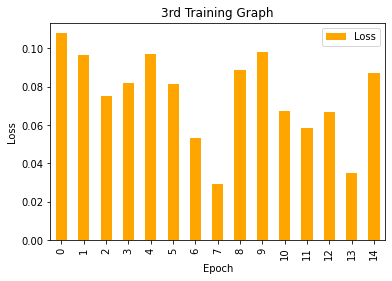

In [ ]:
third_df_pretrained.plot.bar(color='orange')
plt.title('3rd Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# 성능 테스트.
# Mini-batch와 같이 작은 크기 단위로 계산하면 메모리 오류를 피할 수 있다!
n_cnt = 0
ACC = 0.0
my_model.eval()                                                  # 테스트 모드로 전환! Dropout이나 배치 정규화를 off 해준다! .train()의 반대.
with torch.no_grad():                                            # 미분 계산 없이 평가한다!
    for i_batch, my_batch in enumerate(test_loader):
        X_batch, y_batch = my_batch       
        X_batch = preprocess(X_batch.to(my_device))
        y_batch = y_batch.to(my_device)
        y_pred = torch.argmax(my_model(X_batch),axis=1)
        an_acc = torch.mean((y_pred == y_batch).float()).cpu().numpy()
        n_cnt += 1
        ACC += an_acc 
print("Test Accuracy : {}".format(np.round(ACC/n_cnt,3)))

Test Accuracy : 0.893


## 4차 하이퍼 파라미터 최적화 : CNN 알고리즘 적용 (+ VGGNet)

- Pretrained Model 사용 X

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = models.vgg16(pretrained = False).cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 30
fourth_history = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, train_loader)

    fourth_history.append([epoch,test_loss])
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/4326 (0%)]	Loss: 6.902125
[1] Test Loss: 1.0222, accuracy: 27.60%

Train Epoch: 2 [0/4326 (0%)]	Loss: 1.543174
[2] Test Loss: 0.9155, accuracy: 32.11%

Train Epoch: 3 [0/4326 (0%)]	Loss: 1.475383
[3] Test Loss: 0.7967, accuracy: 34.10%

Train Epoch: 4 [0/4326 (0%)]	Loss: 1.166831
[4] Test Loss: 0.7203, accuracy: 40.31%

Train Epoch: 5 [0/4326 (0%)]	Loss: 0.960783
[5] Test Loss: 0.6609, accuracy: 43.94%

Train Epoch: 6 [0/4326 (0%)]	Loss: 0.853991
[6] Test Loss: 0.5789, accuracy: 47.99%

Train Epoch: 7 [0/4326 (0%)]	Loss: 0.956705
[7] Test Loss: 0.6173, accuracy: 46.51%

Train Epoch: 8 [0/4326 (0%)]	Loss: 0.966972
[8] Test Loss: 0.5100, accuracy: 50.90%

Train Epoch: 9 [0/4326 (0%)]	Loss: 0.917589
[9] Test Loss: 0.4858, accuracy: 51.78%

Train Epoch: 10 [0/4326 (0%)]	Loss: 0.652276
[10] Test Loss: 0.4106, accuracy: 53.58%

Train Epoch: 11 [0/4326 (0%)]	Loss: 0.575679
[11] Test Loss: 0.3266, accuracy: 58.65%

Train Epoch: 12 [0/4326 (0%)]	Loss: 0.544996
[12] Test Loss: 

In [ ]:
fourth_history

[[1, 1.0222332311128501],
 [2, 0.915509800639794],
 [3, 0.7967115288468571],
 [4, 0.7202733115250459],
 [5, 0.6609093066006968],
 [6, 0.578912412243974],
 [7, 0.617349202909571],
 [8, 0.509973759459391],
 [9, 0.48576009003475645],
 [10, 0.41058612586280235],
 [11, 0.32663943069817786],
 [12, 0.30488259054916744],
 [13, 0.2281390354691751],
 [14, 0.20837453257084113],
 [15, 0.20149297549996836],
 [16, 0.14149387570040345],
 [17, 0.11256044609812306],
 [18, 0.09950444685106635],
 [19, 0.05879452931718368],
 [20, 0.058345249045848625],
 [21, 0.02693083383387512],
 [22, 0.02110779582696329],
 [23, 0.02697229419993792],
 [24, 0.023722839723864308],
 [25, 0.021789418697060945],
 [26, 0.00858243444217158],
 [27, 0.032162558394163446],
 [28, 0.005845878243270247],
 [29, 0.05413786650833795],
 [30, 0.021191311740306546]]

In [ ]:
# 1. inline for loop 사용
epoch_fourth = [i[0] for i in fourth_history]
print(epoch_fourth)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [ ]:
loss_fourth = []
for i in fourth_history:
    loss_fourth.append(i[1])
print(loss_fourth)

[1.0222332311128501, 0.915509800639794, 0.7967115288468571, 0.7202733115250459, 0.6609093066006968, 0.578912412243974, 0.617349202909571, 0.509973759459391, 0.48576009003475645, 0.41058612586280235, 0.32663943069817786, 0.30488259054916744, 0.2281390354691751, 0.20837453257084113, 0.20149297549996836, 0.14149387570040345, 0.11256044609812306, 0.09950444685106635, 0.05879452931718368, 0.058345249045848625, 0.02693083383387512, 0.02110779582696329, 0.02697229419993792, 0.023722839723864308, 0.021789418697060945, 0.00858243444217158, 0.032162558394163446, 0.005845878243270247, 0.05413786650833795, 0.021191311740306546]


In [ ]:
fourth_df = pd.DataFrame(loss_fourth,epoch_fourth, columns=['Loss'])
fourth_df

,Loss
1,1.022233
2,0.915510
3,0.796712
4,0.720273
5,0.660909
6,0.578912
7,0.617349
8,0.509974
9,0.485760
10,0.410586


- 4차 시각화

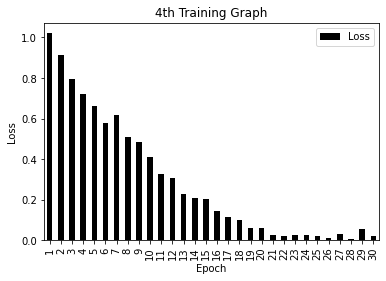

In [ ]:
fourth_df.plot.bar(color='black')
plt.title('4th Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

- Pretrained Model 사용 o

In [ ]:
# 모델을 가져와서 구조를 본다.
my_model = mobilenet_v2(pretrained=True).to(my_device)
print(my_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# "Classifier" 부분만 다시 정의한다.
my_model.classifier = Sequential(Flatten(),
                                Dropout(p=0.5),
                                Linear(in_features=1280, out_features = 1024, bias=True), 
                                ReLU(),
                                Dropout(p=0.5),
                                Linear(in_features=1024, out_features = 256, bias=True), 
                                ReLU(),
                                Linear(in_features=256, out_features = 10, bias=True)).to(my_device)
print(my_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# "Features" 부분의 가중치는 동결.
for params in my_model.features.parameters():
    params.require_grad = False
    
# "Classifier" 부분의 가중치는 추가 학습 허용.
for params in my_model.classifier.parameters():
    params.requires_grad = True

In [ ]:
# MobileNet 입력을 위한 전처리 함수.
def preprocess(X):
    X = 2.0*(X - torch.min(X))/(torch.max(X)-torch.min(X)) -1.0
    return X

In [ ]:
# Hyperparameters.
n_epochs = 16
learn_rate = 0.0003

In [ ]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(my_model.parameters(),lr=learn_rate)

In [ ]:
## 학습.
fourth_pretrained_model = []
for i_epoch in range(n_epochs):
    
    my_loss = []
    
    for i_batch, my_batch in enumerate(train_loader):
        
        if i_batch > 100:                   # 특정 개수의 배치 이후에는 나간다.
            break
       
        X_batch, y_batch = my_batch         # X_batch의 shape는 (batch, channel, height, width)와 같다.
        
        X_batch = preprocess(X_batch.to(my_device))
        
        y_batch = y_batch.to(my_device)
              
        my_optimizer.zero_grad()          # 이전 스텝의 그래디언트 리셋.
    
        y_pred = my_model(X_batch)       # y 예측 계산.
    
        the_loss = cross_entropy(y_pred,y_batch)  # 손실함수 계산.  Softmax함수가 포함됨. 
    
        the_loss.backward()                 # 손실함수에 대한 그래디언트 계산.
    
        my_optimizer.step()               # 경사 하강법 적용.
    
       # my_loss.append(the_loss.item())    # 손실값 저장.
        
        my_loss.append(the_loss.cpu().detach().numpy())    # 손실값 저장. 항상 tensor를 CPU로 꺼내와야 함.
        
    mean_loss = sum(my_loss)/len(my_loss)  
    print(f"Epoch: {i_epoch} , Loss: {np.round(mean_loss, 3)}")
    fourth_pretrained_model.append([i_epoch,mean_loss])

Epoch: 0 , Loss: 0.679
Epoch: 1 , Loss: 0.301
Epoch: 2 , Loss: 0.196
Epoch: 3 , Loss: 0.175
Epoch: 4 , Loss: 0.164
Epoch: 5 , Loss: 0.098
Epoch: 6 , Loss: 0.092
Epoch: 7 , Loss: 0.088
Epoch: 8 , Loss: 0.08
Epoch: 9 , Loss: 0.1
Epoch: 10 , Loss: 0.067
Epoch: 11 , Loss: 0.069
Epoch: 12 , Loss: 0.07
Epoch: 13 , Loss: 0.047
Epoch: 14 , Loss: 0.041
Epoch: 15 , Loss: 0.051


In [ ]:
fourth_pretrained_model

[[0, 0.6789558994926904],
 [1, 0.30084851752770575],
 [2, 0.19569548876269868],
 [3, 0.17478978008423982],
 [4, 0.16371183464009512],
 [5, 0.09752912041976264],
 [6, 0.09178299236503479],
 [7, 0.08799764304421842],
 [8, 0.07950766806392685],
 [9, 0.10019554507085367],
 [10, 0.06682259825205332],
 [11, 0.06900212420456994],
 [12, 0.06964454777587793],
 [13, 0.04664733814516742],
 [14, 0.04121622126993699],
 [15, 0.050925192632099714]]

In [ ]:
# 1. inline for loop 사용
epoch_fourth_pretrained = [i[0] for i in fourth_pretrained_model]
print(epoch_fourth_pretrained)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
loss_fourth_pretrained = []
for i in fourth_pretrained_model:
    loss_fourth_pretrained.append(i[1])
print(loss_fourth_pretrained)

[0.6789558994926904, 0.30084851752770575, 0.19569548876269868, 0.17478978008423982, 0.16371183464009512, 0.09752912041976264, 0.09178299236503479, 0.08799764304421842, 0.07950766806392685, 0.10019554507085367, 0.06682259825205332, 0.06900212420456994, 0.06964454777587793, 0.04664733814516742, 0.04121622126993699, 0.050925192632099714]


In [ ]:
fourth_df_pretrained = pd.DataFrame(loss_fourth_pretrained, epoch_fourth_pretrained, columns=['Loss'])
fourth_df_pretrained

,Loss
0,0.678956
1,0.300849
2,0.195695
3,0.174790
4,0.163712
5,0.097529
6,0.091783
7,0.087998
8,0.079508
9,0.100196


- 4차 Pretrained된 모델 시각화

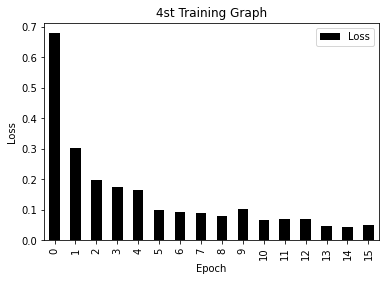

In [ ]:
fourth_df_pretrained.plot.bar(color='black')
plt.title('4st Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# 성능 테스트.
# Mini-batch와 같이 작은 크기 단위로 계산하면 메모리 오류를 피할 수 있다!
n_cnt = 0
ACC = 0.0
my_model.eval()                                                  # 테스트 모드로 전환! Dropout이나 배치 정규화를 off 해준다! .train()의 반대.
with torch.no_grad():                                            # 미분 계산 없이 평가한다!
    for i_batch, my_batch in enumerate(test_loader):
        X_batch, y_batch = my_batch       
        X_batch = preprocess(X_batch.to(my_device))
        y_batch = y_batch.to(my_device)
        y_pred = torch.argmax(my_model(X_batch),axis=1)
        an_acc = torch.mean((y_pred == y_batch).float()).cpu().numpy()
        n_cnt += 1
        ACC += an_acc 
print("Test Accuracy : {}".format(np.round(ACC/n_cnt,3)))

Test Accuracy : 0.919


## 5차 하이퍼 파라미터 최적화 : CNN 알고리즘 적용 (+ mobileNet)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = models.mobilenet_v2(pretrained = False).cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 15
fifth_history = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, train_loader)

    fifth_history.append([epoch,test_loss])
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/4326 (0%)]	Loss: 7.058827
[1] Test Loss: 1.1537, accuracy: 25.47%

Train Epoch: 2 [0/4326 (0%)]	Loss: 1.673451
[2] Test Loss: 0.8842, accuracy: 32.62%

Train Epoch: 3 [0/4326 (0%)]	Loss: 1.368565
[3] Test Loss: 0.7375, accuracy: 40.64%

Train Epoch: 4 [0/4326 (0%)]	Loss: 1.111615
[4] Test Loss: 0.7115, accuracy: 41.93%

Train Epoch: 5 [0/4326 (0%)]	Loss: 1.231510
[5] Test Loss: 0.6216, accuracy: 44.64%

Train Epoch: 6 [0/4326 (0%)]	Loss: 0.641250
[6] Test Loss: 0.5428, accuracy: 48.75%

Train Epoch: 7 [0/4326 (0%)]	Loss: 0.753715
[7] Test Loss: 0.5304, accuracy: 48.82%

Train Epoch: 8 [0/4326 (0%)]	Loss: 0.663871
[8] Test Loss: 0.4411, accuracy: 53.47%

Train Epoch: 9 [0/4326 (0%)]	Loss: 0.852385
[9] Test Loss: 0.4378, accuracy: 53.10%

Train Epoch: 10 [0/4326 (0%)]	Loss: 0.559231
[10] Test Loss: 0.3996, accuracy: 54.46%

Train Epoch: 11 [0/4326 (0%)]	Loss: 0.823142
[11] Test Loss: 0.2978, accuracy: 59.50%

Train Epoch: 12 [0/4326 (0%)]	Loss: 0.609051
[12] Test Loss: 

In [ ]:
fifth_history

[[1, 1.1536906635215642],
 [2, 0.8841869444192365],
 [3, 0.7374605759943849],
 [4, 0.7114636716168069],
 [5, 0.6215799881030827],
 [6, 0.5427881153545829],
 [7, 0.5303797962155212],
 [8, 0.44113310960724683],
 [9, 0.4377546914462629],
 [10, 0.39960400296536186],
 [11, 0.2978494167327881],
 [12, 0.293870366286526],
 [13, 0.21999676349920308],
 [14, 0.22665543937594926],
 [15, 0.30955212225365075]]

In [ ]:
# 1. inline for loop 사용
epoch_fifth = [i[0] for i in fifth_history]
print(epoch_fifth)

# 2. 단순 반복문 사용
# epoch_first = []
# for i in history:
#     epoch_first.append(i[0])
# print(epoch_first)

# 3. zip 사용
#epoch_first = list(zip(*history))[0]

# 4. numpy 사용
# epoch_first = np.array(history).T[0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
loss_fifth = []
for i in fifth_history:
    loss_fifth.append(i[1])
print(loss_fifth)

[1.1536906635215642, 0.8841869444192365, 0.7374605759943849, 0.7114636716168069, 0.6215799881030827, 0.5427881153545829, 0.5303797962155212, 0.44113310960724683, 0.4377546914462629, 0.39960400296536186, 0.2978494167327881, 0.293870366286526, 0.21999676349920308, 0.22665543937594926, 0.30955212225365075]


In [ ]:
fifth_df = pd.DataFrame(loss_fifth,epoch_fifth, columns=['Loss'])
fifth_df

,Loss
1,1.153691
2,0.884187
3,0.737461
4,0.711464
5,0.621580
6,0.542788
7,0.530380
8,0.441133
9,0.437755
10,0.399604


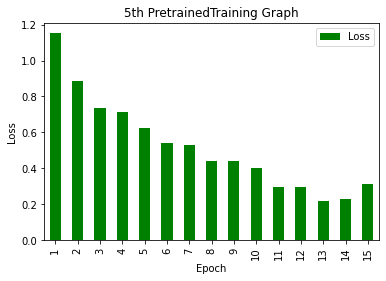

In [ ]:
fifth_df.plot.bar(color='green')
plt.title('5th PretrainedTraining Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

- 5차 학습 시각화

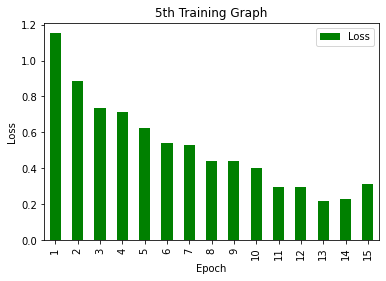

In [ ]:
fifth_df.plot.bar(color='green')
plt.title('5th Training Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# *앙상블 알고리즘 적용*

In [ ]:
print('hi')

hi
